# Model training

In [33]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import optuna

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import shap
import pickle

In [34]:
df = pd.read_excel("data/dataset_cleaned.xlsx")
df

,Codigo_Siniestro,Codigo_Cliente,Fe_Ocurrencia,Codigo_Poliza,Cd_Provincia,Cd_Ciudad,De_Lugar_Ocurrencia,Nu_Siniestro_Relacionado,In_Fraude,De_Causa_Siniestro,...,DESCRIPCION,month,month_sin,month_cos,week,week_sin,week_cos,day,day_sin,day_cos
0,1,7668,2015-05-29,1,29.0,1.0,Siniestro reportado vía cover.,,0,Accidente/Choque,...,DISTRITO NACIONAL,5,5.000000e-01,-0.866025,5,-2.449294e-16,1.000000,29,-0.394356,0.918958
1,2,23643,2016-02-12,2,29.0,1.0,C/ MAYAGUEZ URB. VILLAS DUMIT,,0,Accidente/Choque,...,SAN CRISTOBAL,2,8.660254e-01,0.500000,2,5.877853e-01,-0.809017,12,0.651372,-0.758758
2,3,29730,2016-02-09,3,1.0,1.0,Barahora,,0,Responsabilidad Civil Personas o Cosas,...,BARAHONA,2,8.660254e-01,0.500000,2,5.877853e-01,-0.809017,9,0.968077,-0.250653
3,4,14301,2016-02-15,4,1.0,1.0,Arroyo Hondo II,,0,Robo o Hurto Accesorios/ Partes o Piezas,...,DISTRITO NACIONAL,2,8.660254e-01,0.500000,3,-5.877853e-01,-0.809017,15,0.101168,-0.994869
4,5,24144,2016-02-03,5,1.0,1.0,Avenida Gustavo Mejia Ricart,,0,Accidente/Choque,...,DISTRITO NACIONAL,2,8.660254e-01,0.500000,1,9.510565e-01,0.309017,3,0.571268,0.820763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,18702,192804,2023-04-04,11379,1.0,1.0,AUTOPISTA DUARTE,,0,Rotura de Vidrios y/o Parabrisas,...,SANTO DOMINGO,4,8.660254e-01,-0.500000,1,9.510565e-01,0.309017,4,0.724793,0.688967
17437,18703,181905,2023-06-03,11470,1.0,1.0,LOS MULTIS LOS ALCARRIZOS,,0,Rotura de Vidrios y/o Parabrisas,...,SANTO DOMINGO,6,1.224647e-16,-1.000000,1,9.510565e-01,0.309017,3,0.571268,0.820763
17438,18704,182109,2023-05-22,11471,1.0,1.0,AUTOPISTA DUARTE,,0,Rotura de Vidrios y/o Parabrisas,...,SANTO DOMINGO,5,5.000000e-01,-0.866025,4,-9.510565e-01,0.309017,22,-0.968077,-0.250653
17439,18705,302838,2023-06-01,11472,1.0,1.0,CALLE CAMINO CHIQUITO,,0,Accidente/Choque,...,DISTRITO NACIONAL,6,1.224647e-16,-1.000000,1,9.510565e-01,0.309017,1,0.201299,0.979530


In [35]:
df.Codigo_Siniestro.nunique()

17405

In [36]:
df.isnull().sum()

Codigo_Siniestro    0
Codigo_Cliente      0
Fe_Ocurrencia       0
Codigo_Poliza       0
Cd_Provincia        1
                   ..
week_sin            0
week_cos            0
day                 0
day_sin             0
day_cos             0
Length: 75, dtype: int64

In [37]:
df.Cantidad_Parque_Vehicular.value_counts()

Cantidad_Parque_Vehicular
621291     1600
419442     1389
569102     1383
449918     1343
487157     1286
           ... 
2695457       1
21213         1
2573494       1
17018         1
3063704       1
Name: count, Length: 61, dtype: int64

In [39]:
df[['longitude','latitude','tavg','dia_feriado','Clima_Fog','Clima_Thunderstorm','pres','prcp']].dtypes

longitude             float64
latitude              float64
tavg                  float64
dia_feriado             int64
Clima_Fog               int64
Clima_Thunderstorm      int64
pres                  float64
prcp                  float64
dtype: object

In [40]:
# Group in a monthly format
groupby_columns = ['PROVINCIA','ano','month','De_Causa_Siniestro', #'Marca', 'Año',
                   'Categoria_Lugar','Clase']

def mode(x):
    '''Get the mode of the specified column.'''
    return stats.mode(x)[0]

tranformations = {  'latitude':'median',
                    'longitude':'median',
                    'tavg':'median',
                    'prcp':'median',
                    'wdir':'median',
                    'wspd':'median',
                    'pres':'median',
                    'dia_feriado':mode,
                    'Clima_Cloudy':mode,
                    # 'Clima_Fair':mode,
                    'Clima_Fog':mode,
                    'Clima_Rain':mode,
                    'Clima_Thunderstorm':mode,
                    'Codigo_Siniestro':'count' # Creacion de la serie de tiempo de frecuencia
}

frequency_data = df.groupby(groupby_columns).agg(tranformations).reset_index()
frequency_data.rename(columns={"Codigo_Siniestro":"conteo_siniestros"}, inplace=True)
frequency_data

,PROVINCIA,ano,month,De_Causa_Siniestro,Categoria_Lugar,Clase,latitude,longitude,tavg,prcp,wdir,wspd,pres,dia_feriado,Clima_Cloudy,Clima_Fog,Clima_Rain,Clima_Thunderstorm,conteo_siniestros
0,BARAHONA,2015,7,Accidente/Choque,Calle,Automovil,18.201755,-71.097700,31.6,0.0,113.0,17.6,1018.3,0,0,0,1,0,1
1,BARAHONA,2015,8,Accidente/Choque,Calle,Jeep,18.191326,-71.099478,30.8,0.0,113.0,17.6,1018.3,0,0,0,1,0,1
2,BARAHONA,2015,10,Rotura de Vidrios y/o Parabrisas,Otro,Automovil,18.212081,-71.102408,31.1,0.0,113.0,17.6,1018.3,0,0,0,1,0,1
3,BARAHONA,2015,11,Accidente/Choque,Otro,Automovil,18.217946,-71.103478,28.1,0.0,113.0,17.6,1018.3,0,0,0,0,1,1
4,BARAHONA,2015,12,Rotura de Vidrios y/o Parabrisas,Otro,Automovil,18.212081,-71.102408,28.4,0.0,113.0,17.6,1018.3,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7105,SANTO DOMINGO,2023,6,Rotura de Vidrios y/o Parabrisas,Otro,Automovil,18.473806,-69.994434,26.8,2.6,103.0,19.7,1016.3,0,0,0,0,0,1
7106,SANTO DOMINGO,2023,6,Rotura de Vidrios y/o Parabrisas,Otro,Jeep,18.535209,-69.937395,27.1,1.8,158.0,20.8,1015.2,0,1,0,0,0,3
7107,SANTO DOMINGO,2023,7,Accidente/Choque,Autopista,Automovil,18.489758,-69.823730,27.0,0.9,104.0,15.3,1015.0,0,1,0,0,0,1
7108,SANTO DOMINGO,2023,7,Accidente/Choque,Avenida,Jeep,18.451620,-69.979564,27.3,0.8,40.0,12.3,1015.5,0,1,0,0,0,1


In [41]:
frequency_data.conteo_siniestros.sum()

17441

<Axes: >

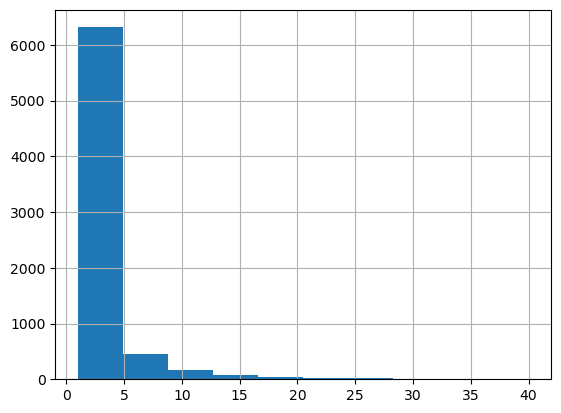

In [42]:
frequency_data.conteo_siniestros.hist()

In [43]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

frequency_data = encode(frequency_data, 'month', 12)

In [44]:
frequency_data.De_Causa_Siniestro.value_counts()

De_Causa_Siniestro
Accidente/Choque                            3684
Rotura de Vidrios y/o Parabrisas            1543
Responsabilidad Civil Personas o Cosas      1277
Robo o Hurto Accesorios/ Partes o Piezas     293
No Registrado                                134
Daños Maliciosos al Vehículo/APOV             94
Hechos de la Naturaleza                       65
Robo o Hurto  Vehiculo                        20
Name: count, dtype: int64

### LabelEncoder for categorical variables and test train split

In [45]:
X = frequency_data.drop('conteo_siniestros', axis=1)
y = frequency_data['conteo_siniestros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Instanciar el escalador estándar y el codificador one hot
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)

col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
col_transformer.fit(X_train)

X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

X_valid_processed = col_transformer.transform(X_valid)

variables = []

for x in list(col_transformer.get_feature_names_out()):
    x_ = x.replace('standardscaler_','').replace('onehotencoder_','')
    variables.append(x_)

X_train = pd.DataFrame(X_train_processed, columns = variables, index = X_train.index)
X_test = pd.DataFrame(X_test_processed, columns = variables, index = X_test.index)
X_valid = pd.DataFrame(X_valid_processed, columns = variables, index = X_valid.index)
X_train.head()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,_ano,_month,_latitude,_longitude,_tavg,_prcp,_wdir,_wspd,_pres,_dia_feriado,...,_Categoria_Lugar_Autopista,_Categoria_Lugar_Avenida,_Categoria_Lugar_Calle,_Categoria_Lugar_Otro,_Clase_Autobus,_Clase_Automovil,_Clase_Carga,_Clase_Jeep,_Clase_Maquinaria Pesada,_Clase_Motocicleta
3594,-0.792452,-1.626906,0.060456,-0.360407,-0.678512,-0.272884,0.270710,-0.798139,0.444834,-0.111629,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1250,0.415608,-1.334759,-0.587432,0.024076,0.270900,-0.272884,-0.459162,-0.532659,1.406703,-0.111629,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6925,1.220981,0.710270,-0.589988,-0.044201,-0.189421,-0.016608,-0.897085,-0.460255,-0.812995,-0.111629,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5684,-1.195138,-0.750465,-0.592686,0.235454,-1.282682,0.195482,-0.659876,-0.025832,-0.110091,-0.111629,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4595,1.220981,0.125976,0.060456,-0.360407,0.098280,-0.228698,-1.061306,0.215514,0.999758,-0.111629,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Check to see if the model has multicollinearity

In [46]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

calculate_vif(X_train)

divide by zero encountered in scalar divide


,Variable,VIF
0,_ano,2.008314
1,_month,2.829322
2,_latitude,42.752145
3,_longitude,62.784071
4,_tavg,2.996493
5,_prcp,1.174384
6,_wdir,1.478798
7,_wspd,1.381988
8,_pres,1.449126
9,_dia_feriado,1.024627


## Training

In [47]:
# Lista de modelos de regresión
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('SVR', SVR()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('ExtraTrees', ExtraTreesRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('Bagging', BaggingRegressor()))
models.append(('BayesianRidge', BayesianRidge()))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('XGBoost', XGBRegressor()))
models.append(('LightGBM', LGBMRegressor()))
models.append(('CatBoost', CatBoostRegressor()))

In [48]:
# Guardamos los resultados del modelo
resultados = []
nombres = []
scoring = 'neg_root_mean_squared_error'
# como métrica de puntuación en Scikit-learn, estás expresando tu deseo de maximizar el valor negativo del MSE, lo que equivale a minimizar el MSE real.

for nombre, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_resultados = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultados.append(cv_resultados)
    nombres.append(nombre)
    msg = ('{}: {} ({})'.format(nombre, cv_resultados.mean(), cv_resultados.std()))
    print(msg)

LR: -2.913663786267988 (0.2875294230434003)
Ridge: -2.913299143490769 (0.2875188899055226)
Lasso: -3.378877364957232 (0.37635667577787046)
ElasticNet: -3.3702349683472006 (0.3772164820315882)
SVR: -2.987798739930379 (0.3658758496439384)
DecisionTree: -2.132337306682904 (0.14733987613584257)
ExtraTrees: -1.6673710105465986 (0.1509163257061293)
AdaBoost: -3.1636560274061996 (0.17148136997033478)
Bagging: -1.699152398720702 (0.17505987857450223)
BayesianRidge: -2.9132700672161604 (0.2899967938682255)
GradientBoosting: -2.0181496449294527 (0.13206992777548537)
RandomForest: -1.6461700818399454 (0.16466715047718464)
KNN: -2.8757562056731785 (0.21504889153860526)
XGBoost: -1.610407340997504 (0.1509988104439403)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

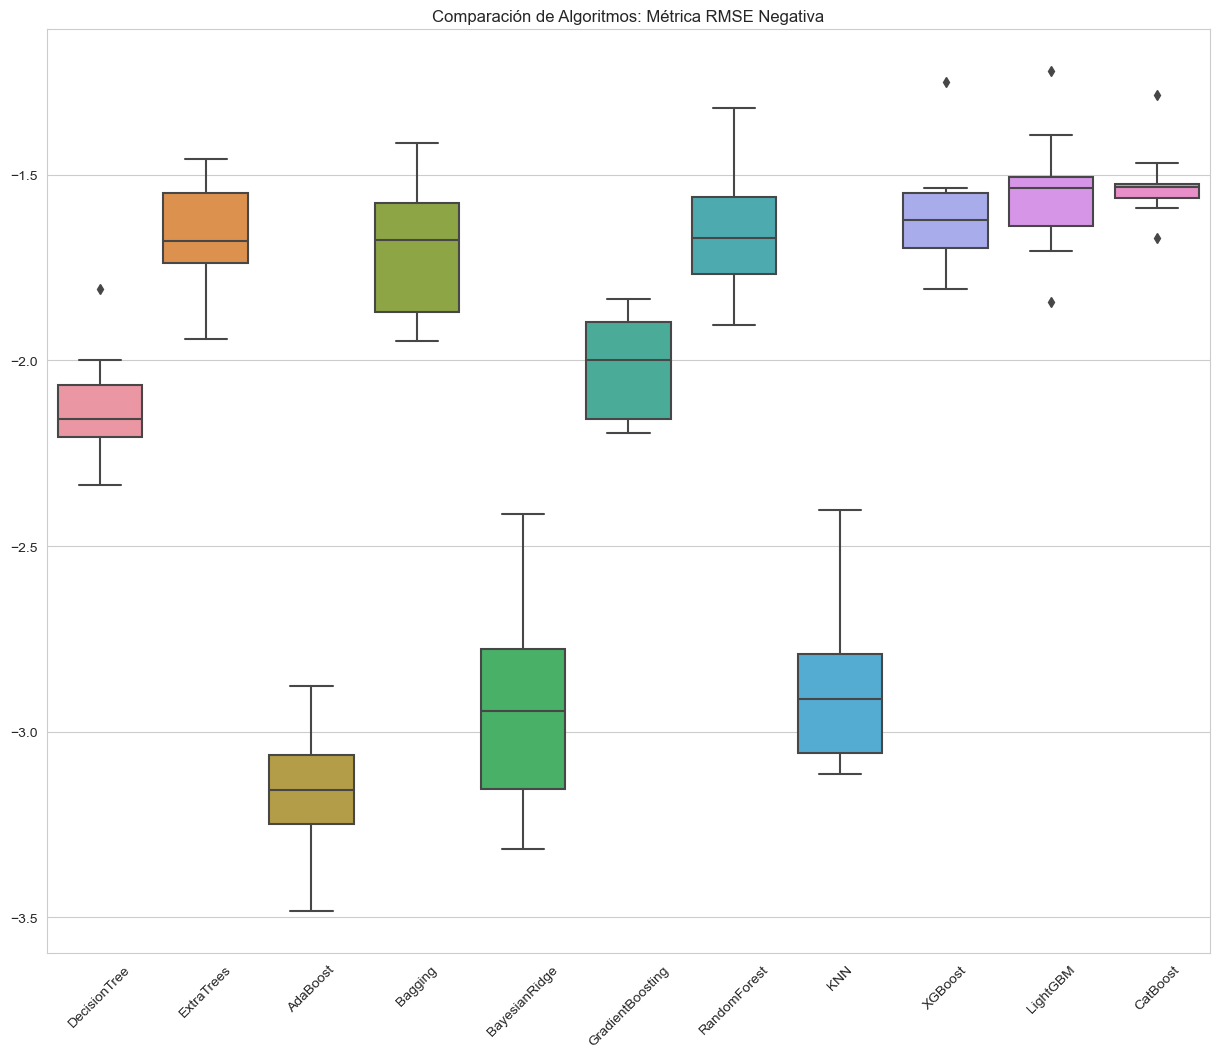

In [49]:
#  Graficamos para tener mejor ilustracion
plot = pd.DataFrame(resultados[5:], index=nombres[5:]).T

sns.set_style("whitegrid")
plt.figure(figsize=(15, 12))
sns.boxplot(data=plot)
plt.title('Comparación de Algoritmos: Métrica RMSE Negativa')
plt.xticks(rotation=45)
plt.show()

En este gráfico podemos ver que la elección óptima del modelo sería `CatBoostRegressor`.

## Using Optuna for Hyperparameter Tuning 

In [80]:
def objective(trial):
    """
    Hallar los parametros optimos mediante Optuna.
    """
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),  # Regularizacion
        'border_count': trial.suggest_int('border_count', 32, 255)
    }    
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return np.sqrt(mse)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Mejores parametros: ", study.best_params)
print("Mejor score: ", study.best_value)

[I 2023-08-20 06:19:54,287] A new study created in memory with name: no-name-ced37692-ce38-493a-855f-022caaa041f5
[I 2023-08-20 06:19:56,127] Trial 0 finished with value: 1.613738697063868 and parameters: {'iterations': 275, 'depth': 7, 'learning_rate': 0.08543542053511684, 'l2_leaf_reg': 3.3286136359077663, 'border_count': 153}. Best is trial 0 with value: 1.613738697063868.
[I 2023-08-20 06:20:12,321] Trial 1 finished with value: 1.5864897675828686 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.06200717059543337, 'l2_leaf_reg': 6.99398378572736, 'border_count': 165}. Best is trial 1 with value: 1.5864897675828686.
[I 2023-08-20 06:20:19,623] Trial 2 finished with value: 1.7123760933033105 and parameters: {'iterations': 303, 'depth': 7, 'learning_rate': 0.3742770473068846, 'l2_leaf_reg': 3.5310684963283645, 'border_count': 176}. Best is trial 1 with value: 1.5864897675828686.
[I 2023-08-20 06:20:23,046] Trial 3 finished with value: 1.6076296755605575 and parameters

Mejores parametros:  {'iterations': 450, 'depth': 10, 'learning_rate': 0.06278426507160378, 'l2_leaf_reg': 7.70068618981838, 'border_count': 200}
Mejor score:  1.5713387511105128


Train the model with the optimized hyperparameters

In [82]:
best_params = study.best_params
best_params.update({
    'od_type': 'Iter',
    'od_wait': 50,
    'eval_metric': 'RMSE',
    'verbose': False
})
model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 1.571593894972823


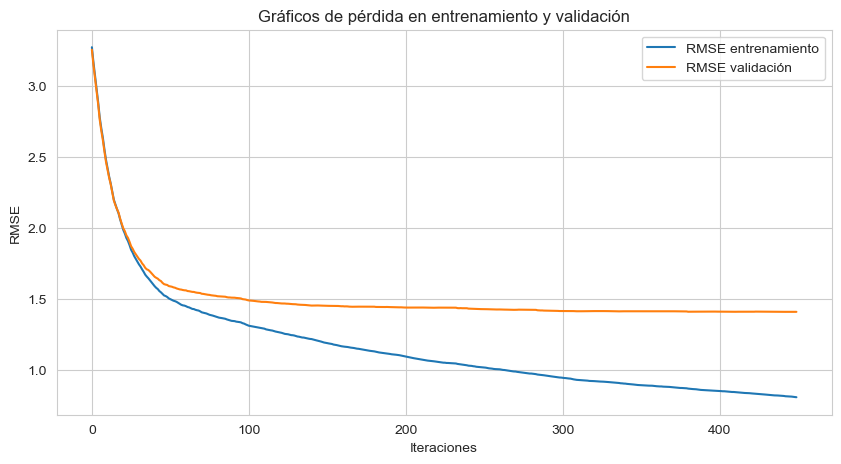

In [86]:
evals_result = model.get_evals_result()

# Extraer RMSE
train_rmse = evals_result['learn']['RMSE']
valid_rmse = evals_result['validation']['RMSE']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='RMSE entrenamiento')
plt.plot(valid_rmse, label='RMSE validación')
plt.xlabel('Iteraciones')
plt.ylabel('RMSE')
plt.legend()
plt.title('Gráficos de pérdida en entrenamiento y validación')
plt.show()

## Model evaluation and explicability

Metric obtained: `RMSE` = 1.571593894972823

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


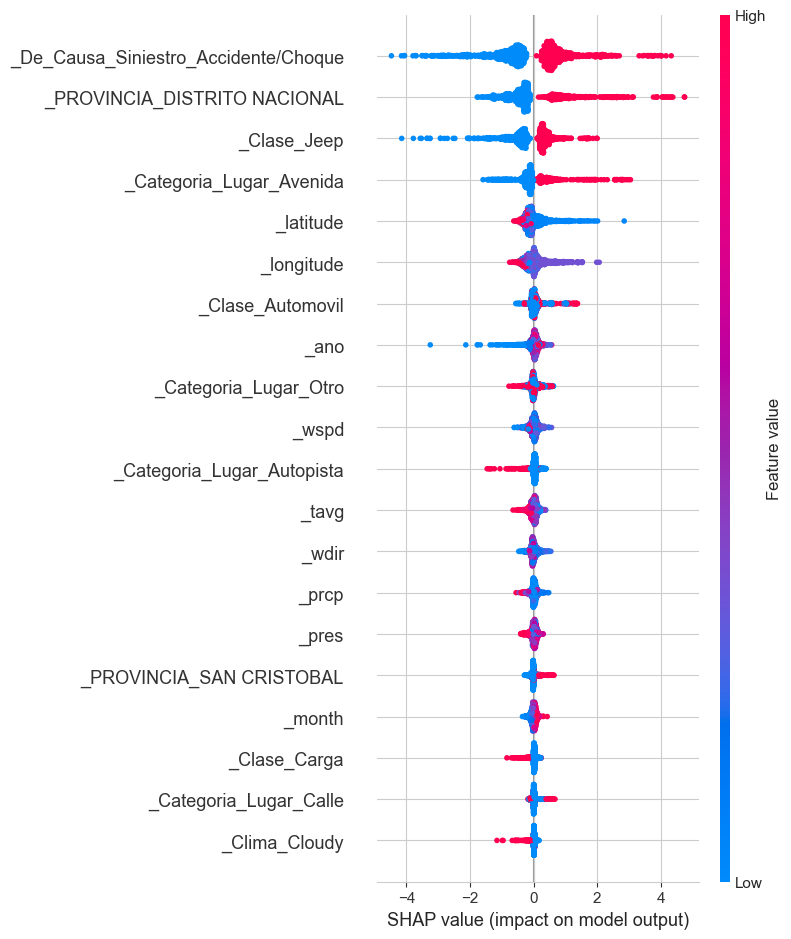

In [88]:
explainer = shap.Explainer(model)

shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

shap.summary_plot(shap_values, X_test)

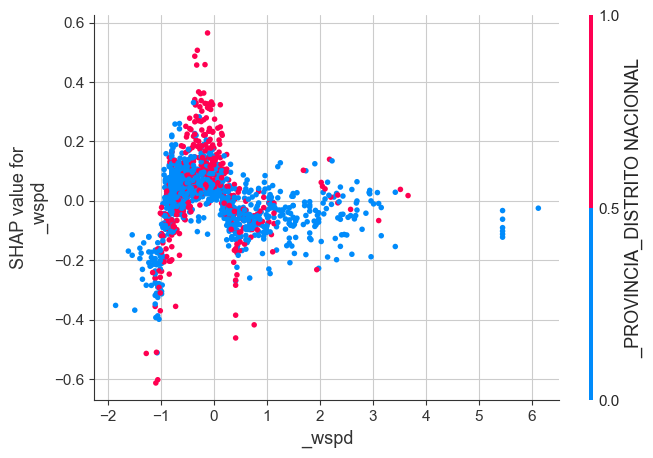

In [90]:
shap.dependence_plot("_wspd", shap_values, X_test)
# Comparacion entre el impacto de la velicidad del viento
# con que ocurra un accidente dentro del Distrito Nacional

## Shock impact analysis

Aplicacion de un modelo impulso-respuesta